   # MLP in Pytorch

**Partea 1** Sa se creeze si antreneze un model de tip MLP, folosind setul de date MNIST. Arhitecura modelului - numarul de neuroni in straturile ascunse - va fi data ca o lista de intregi, de exemplu:
`architecture=[100, 40, 20]` reprezinta o retea MLP cu 3 straturi ascunse, cu cate 100, 40, respectiv 20 de neuroni in straturile ascunse. Se va transmite, de asemenea functia de activare folosita pentru straturile ascunse. Se vor tipari (pe masura ce se antreneaza) si reprezenta grafic (la final de instruire): loss pe setul de antrenare, loss si acuratete pe setul de testare pentru fiecare de instruire.

**Partea a doua**. Automatizati procesul de cautare pentru arhitectura retelei si learnign rate:
1. Definiti o lista de learnign rates candidate, e.g. lrs = [1e-2, 1e-3, 1e-4]
1. Definiti o lista de arhitecturi candidate, e.g. architectures=[[100, 40, 20], [200, 40]]
1. Iterati peste toate combinatiile de learnign rate si arhitecturi; antrenati cate un model pe fiecare combinatie in parte, testati pe setul de testare. Retineti acea combinatie (lr, architecture) care duce la acuratete maxima pe setul de testare. 
1. Optional, puteti adauga alti hiperparametri pentru modele: valoarea coeficientului de momentum si weight decay pentru SGD, numarul de epoci.

Note: 
1. Pentru adaugarea de module la structura retelei se poate folosi clasa [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). 
1. Functiile de activare se pot alege din cele [definite in Pytorch].(https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

Termen de predare: 11 ian 2025, 08:00

Se vor folosi type annotations pentru variabile, parametrii tuturor funcțiilor, tipuri de retur. Tema se noteaza doar in prezenta studentului; rezolvarile sunt individuale.

Se acordă doua puncte din oficiu. Fișierul va fi denumit tema5_ia_nume_prenume.ipynb. Verificați înainte de trimitere faptul ca execuția celulelor de sus în jos funcționează corespunzător.

## Setup

In [1]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from typing import List, Tuple
import matplotlib.pyplot as plt
from torchsummary import summary
from typing import Tuple

In [2]:
device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

## Setul de date

In [3]:
# NOTE(LUIGI): Arbitrary value
batch_size : int = 20 

In [4]:
# transformarea ToTensor transforma datele in tensori PyTorch si scaleaza datele
# in intervalul [0, 1]
# doc: https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# setul de date MNIST este pus la dispozitie prin pachetul torchvision
# doc: https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST
train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

In [5]:
# Loaders for batches
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

## Definirea MLP

### Modelul

In [6]:
class MLP_Dynamic(nn.Module):
    """
    MLP model with dynamic architecture
    """
    def __init__(self, 
                 input_size: int = 784, 
                 hidden_architecture: List[int] = [100, 40, 20],
                 activation_fx : torch.nn.modules.activation = torch.nn.Tanh(),
                 n_classes: int = 10):
        """
        Initializes MLP model with:
        :param input_size: input size for current nn
        :hidden_architecture: A list of ints of length equal to the number of hidden layers and each element equal to the number of neurons in that layer
        :activation_fx: the activation function used for all hidden layers
        :n_classes: output size
        """
        super().__init__()
        # Define linear layers list (will have linear layers, each followed by activation fx)
        linear_layers = []
        # Create nn.Linear layers based on hidden_architecture and input_size, add activation functions

        # NOTE(LUIGI): We do this because it's a dynamic model. Can't use hardcoded props such as self.matrix0 = nn.Linear(...)
        prev_size: int = input_size
        for layer_size in hidden_architecture:
            linear_layers.append(nn.Linear(in_features=prev_size, out_features=layer_size))
            linear_layers.append(activation_fx)
            prev_size = layer_size

        self.hidden_layers = nn.Sequential(*linear_layers)
        self.output_layer = nn.Linear(prev_size, n_classes)
        
    def forward(self, x):
        # Transform MNIST image of size 1x28x28 to 1D tensor of size 784
        x = x.view(x.size(0), -1)
        
        # Propagate through flow defined by self.hidden_layers
        y = self.hidden_layers(x)
        
        # propagare spre stratul de iesire
        z = self.output_layer(y)
        return z

### Functii antrenare, testare

In [7]:
@torch.no_grad()
def test(model: nn.Module, 
         criterion: nn.CrossEntropyLoss, 
         loader: torch.utils.data.DataLoader, 
         device: torch.device) -> Tuple[float, float]:
    """
    Test the given model on data provided by :param test_loader:
    
    :param model: the modeul used for inference
    :param criterion: loss function
    :param loader: the dataloader used to fetch the data
    :param device: the device used to run the model
    
    :return: accuracy and loss on the test data.
    """
    # se trece modelul in mod de evaluare
    model.eval()
    # acumulatori de performanta
    
    total_inputs: int = 0
    correctly_classified: torch.Tensor = 0
    test_loss: float = 0

    for input, expected_output in loader:
        input, expected_output = input.to(device), expected_output.to(device)

        # extract predictions for current minibatch;
        y_hat: torch.Tensor = model(input)
        # extract best scoring class for each input value in minibatch
        predicted_class: torch.Tensor = torch.argmax(y_hat, dim=1)
        # count correctly classified values
        correctly_classified += (predicted_class == expected_output).sum().item()
        total_inputs += expected_output.size(0)

        # calculate loss for current minibatch
        loss = criterion(y_hat, expected_output)
        test_loss += loss.item() * expected_output.size(0)

    accuracy  = correctly_classified / total_inputs
    test_loss = test_loss / total_inputs

    return accuracy, test_loss

In [8]:
def train(model: nn.Module, 
          epochs: int, 
          criterion: nn.CrossEntropyLoss,
          optimizer: torch.optim.SGD,
          train_loader: torch.utils.data.DataLoader, 
          test_loader: torch.utils.data.DataLoader,
          device: torch.device) -> None:
    """
    Train a model on the given :param train_loader: loader, for :param epochs: epochs, on the specified
    :param device:, using :param optimizer: optimizer.
    At the end of the training will plot accuracy and loss for training and test data.
    """
    train_losses : List[float] = []
    test_accuracies : List[float] = []
    test_losses : List[float] = []
    test_accuracy_untrained, test_loss_untrained = test(model, criterion, test_loader, device)
    print(f'On untrained model, test set: acc={test_accuracy_untrained*100:.2f}, loss={test_loss_untrained:.4f}')
    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss : float = 0
        total_items: int = 0

        for x, y in train_loader:
            # transfer de date catre device
            x, y = x.to(device), y.to(device)
            
            # predictie 
            y_hat : torch.Tensor = model(x)
            
            # calcul valoare de eroare
            loss : float = criterion(y_hat, y)
            
            # eroarea loss e media peste datele din minibatch, deci trebuie sa inmultim ca numarul
            # de date din batch pentru a avea loss-ul total pe minibatch
            running_train_loss += loss.item() * x.size(0)
            total_items += x.size(0)

            # resetare gradienti, pentru a evita acumularea peste gradientii precedenti
            optimizer.zero_grad()
            
            # calcul gradienti
            loss.backward()
            
            # se modifica ponderile curente
            optimizer.step()
        
        # adaugati costurile in listele de losses, calculati acuratetile
        train_losses.append(running_train_loss / total_items)
        test_accuracy, test_loss = test(model, criterion, test_loader, device)
        print(f'Epoch {epoch}/{epochs}, train set: loss={train_losses[-1]:.4f}')
        print(f'Epoch {epoch}/{epochs}, test set: acc={test_accuracy*100:.2f}%, loss={test_loss:.4f}')
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
    # Creati un singur plot care sa afiseze costurile de antrenare si testare
    plt.figure(figsize=(8, 4.5))
    plt.title('Loss curves')
    plt.plot(range(len(train_losses)), train_losses, label='Train losses')
    plt.plot(range(len(test_losses)), test_losses, label='Train losses')
    plt.xlabel('Epochs (n)')
    plt.ylabel('Loss')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.5)
    plt.show()
    
    # Creati un plot care sa afiseze acuratetile
    plt.figure(figsize=(8, 4.5))
    plt.title('Accuracy curve')
    plt.plot(range(len(test_accuracies)), train_losses, label='Test accuracy')
    plt.xlabel('Epochs (n)')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.5)
    plt.show()

## Antrenarea modelului - partea 1

In [9]:
# Define model (the other parameters are left as default)
model = MLP_Dynamic(activation_fx=torch.nn.modules.activation.Tanh())
# Move model to device
model.to(device)

MLP_Dynamic(
  (hidden_layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=40, bias=True)
    (3): Tanh()
    (4): Linear(in_features=40, out_features=20, bias=True)
    (5): Tanh()
  )
  (output_layer): Linear(in_features=20, out_features=10, bias=True)
)

In [10]:
summary(model, device=device)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       78,500
|    └─Tanh: 2-2                         --
|    └─Linear: 2-3                       4,040
|    └─Linear: 2-4                       820
├─Linear: 1-2                            210
Total params: 83,570
Trainable params: 83,570
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       78,500
|    └─Tanh: 2-2                         --
|    └─Linear: 2-3                       4,040
|    └─Linear: 2-4                       820
├─Linear: 1-2                            210
Total params: 83,570
Trainable params: 83,570
Non-trainable params: 0

In [16]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Alegeti hiperparametri
epochs : int = 30
lr : float = 0.01
momentum : float = 0.9
weight_decay : float = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr, momentum, weight_decay)

On untrained model, test set: acc=10.28, loss=505.9190
Epoch 1/30, train set: loss=269.1859
Epoch 1/30, test set: acc=11.35%, loss=149.4980
Epoch 2/30, train set: loss=112.8060
Epoch 2/30, test set: acc=10.28%, loss=82.5352
Epoch 3/30, train set: loss=55.0288
Epoch 3/30, test set: acc=10.10%, loss=26.1223
Epoch 4/30, train set: loss=7.4253
Epoch 4/30, test set: acc=10.28%, loss=2.3321
Epoch 5/30, train set: loss=2.3248
Epoch 5/30, test set: acc=10.28%, loss=2.3108
Epoch 6/30, train set: loss=2.3248
Epoch 6/30, test set: acc=9.58%, loss=2.3291
Epoch 7/30, train set: loss=2.3250
Epoch 7/30, test set: acc=10.28%, loss=2.3201
Epoch 8/30, train set: loss=2.3250
Epoch 8/30, test set: acc=10.09%, loss=2.3222
Epoch 9/30, train set: loss=2.3244
Epoch 9/30, test set: acc=10.10%, loss=2.3070
Epoch 10/30, train set: loss=2.3254
Epoch 10/30, test set: acc=9.82%, loss=2.3127
Epoch 11/30, train set: loss=2.3257
Epoch 11/30, test set: acc=10.10%, loss=2.3235
Epoch 12/30, train set: loss=2.3253
Epoch 1

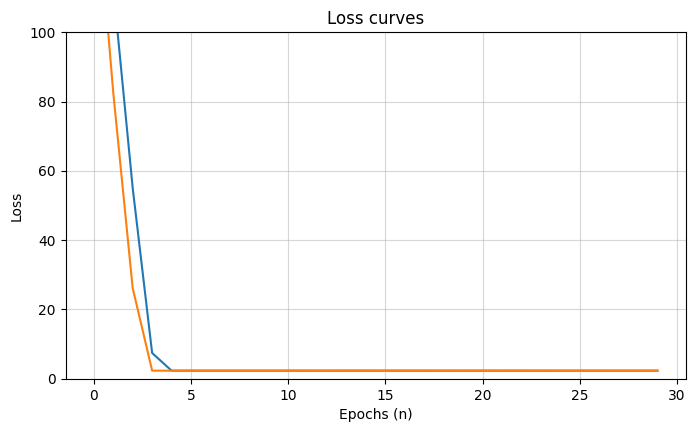

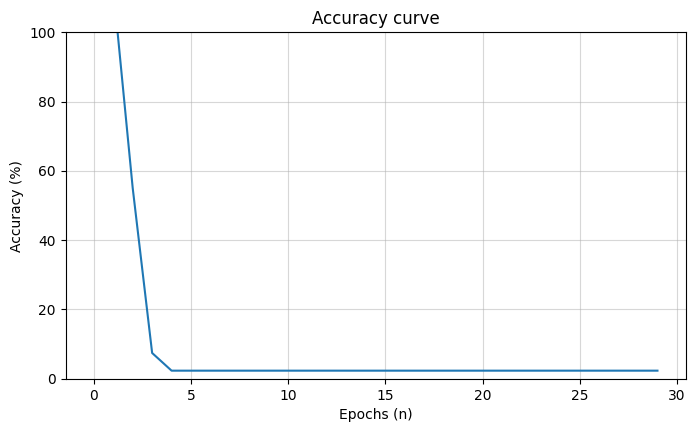

In [17]:
train(model, epochs, criterion, optimizer, train_loader, test_loader, device)

## Antrenarea modelului - Partea 2

In [13]:
import itertools

In [14]:
candidate_lrs : List[float] = [1e-2, 1e-3, 1e-4]
candidate_architectures : List[List[int]] = [[100, 40, 20], [200, 40]]

In [21]:
epochs : int = 30
momentum : float = 0.09
weight_decay : float = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

max_accuracy : float = 99.69
best_performing_params: Tuple[int, int] = None # Tuple of lr, candidate_architecture
best_performing_model : MLP_Dynamic = None

On untrained model, test set: acc=10.10, loss=2.3118
Epoch 1/30, train set: loss=2.3461
Epoch 1/30, test set: acc=10.09%, loss=2.3545
Epoch 2/30, train set: loss=2.3458
Epoch 2/30, test set: acc=8.92%, loss=2.3279
Epoch 3/30, train set: loss=2.3450
Epoch 3/30, test set: acc=9.82%, loss=2.3188
Epoch 4/30, train set: loss=2.3449
Epoch 4/30, test set: acc=10.09%, loss=2.3378
Epoch 5/30, train set: loss=2.3451
Epoch 5/30, test set: acc=9.74%, loss=2.3272
Epoch 6/30, train set: loss=2.3469
Epoch 6/30, test set: acc=8.92%, loss=2.3560
Epoch 7/30, train set: loss=2.3715
Epoch 7/30, test set: acc=10.09%, loss=2.3743
Epoch 8/30, train set: loss=2.4060
Epoch 8/30, test set: acc=8.94%, loss=2.3566
Epoch 9/30, train set: loss=2.4797
Epoch 9/30, test set: acc=10.20%, loss=2.6894
Epoch 10/30, train set: loss=3.1048
Epoch 10/30, test set: acc=9.34%, loss=3.6394
Epoch 11/30, train set: loss=6.9282
Epoch 11/30, test set: acc=9.97%, loss=12.4348
Epoch 12/30, train set: loss=15.4553
Epoch 12/30, test set

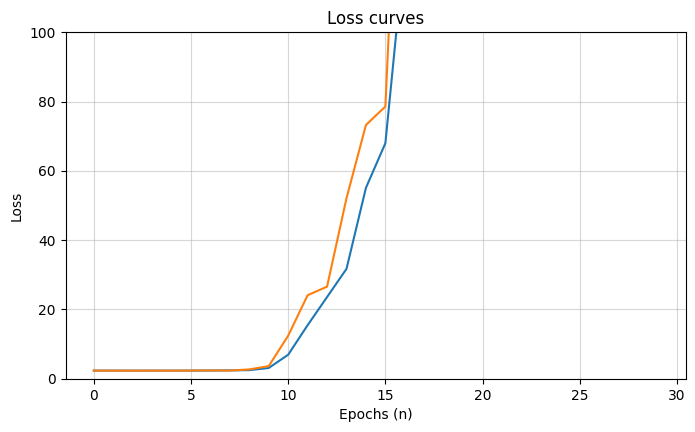

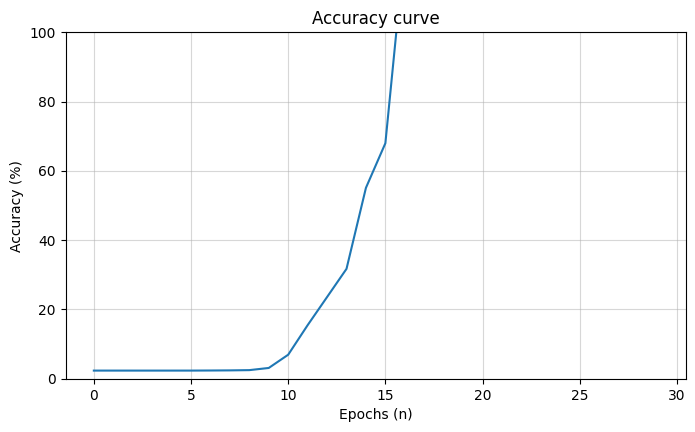

In [22]:
model_adam = MLP_Dynamic(activation_fx=torch.nn.modules.activation.Tanh())

model.to(device)

train(model, epochs, criterion, optimizer, train_loader, test_loader, device)

Training: lr=0.01, arhitecture=[100, 40, 20]
On untrained model, test set: acc=4.96, loss=2.3210
Epoch 1/30, train set: loss=0.9929
Epoch 1/30, test set: acc=88.97%, loss=0.4049
Epoch 2/30, train set: loss=0.3368
Epoch 2/30, test set: acc=92.39%, loss=0.2711
Epoch 3/30, train set: loss=0.2422
Epoch 3/30, test set: acc=94.10%, loss=0.2115
Epoch 4/30, train set: loss=0.1902
Epoch 4/30, test set: acc=94.96%, loss=0.1743
Epoch 5/30, train set: loss=0.1588
Epoch 5/30, test set: acc=95.74%, loss=0.1476
Epoch 6/30, train set: loss=0.1382
Epoch 6/30, test set: acc=95.76%, loss=0.1474
Epoch 7/30, train set: loss=0.1237
Epoch 7/30, test set: acc=96.50%, loss=0.1226
Epoch 8/30, train set: loss=0.1116
Epoch 8/30, test set: acc=96.49%, loss=0.1161
Epoch 9/30, train set: loss=0.1017
Epoch 9/30, test set: acc=96.77%, loss=0.1081
Epoch 10/30, train set: loss=0.0950
Epoch 10/30, test set: acc=96.93%, loss=0.1002
Epoch 11/30, train set: loss=0.0879
Epoch 11/30, test set: acc=96.80%, loss=0.1065
Epoch 12

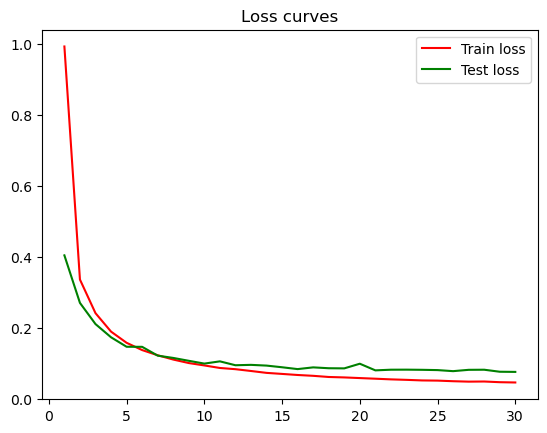

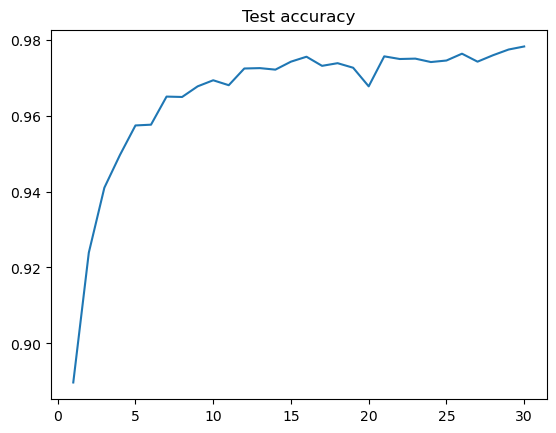

Training: lr=0.01, arhitecture=[200, 40]
On untrained model, test set: acc=8.44, loss=2.3151
Epoch 1/30, train set: loss=0.6952
Epoch 1/30, test set: acc=91.18%, loss=0.3223
Epoch 2/30, train set: loss=0.3011
Epoch 2/30, test set: acc=92.33%, loss=0.2684
Epoch 3/30, train set: loss=0.2553
Epoch 3/30, test set: acc=93.42%, loss=0.2320
Epoch 4/30, train set: loss=0.2239
Epoch 4/30, test set: acc=94.04%, loss=0.2083
Epoch 5/30, train set: loss=0.1975
Epoch 5/30, test set: acc=94.59%, loss=0.1867
Epoch 6/30, train set: loss=0.1762
Epoch 6/30, test set: acc=95.34%, loss=0.1662
Epoch 7/30, train set: loss=0.1589
Epoch 7/30, test set: acc=95.42%, loss=0.1551
Epoch 8/30, train set: loss=0.1458
Epoch 8/30, test set: acc=95.72%, loss=0.1455
Epoch 9/30, train set: loss=0.1343
Epoch 9/30, test set: acc=96.13%, loss=0.1352
Epoch 10/30, train set: loss=0.1255
Epoch 10/30, test set: acc=96.19%, loss=0.1306
Epoch 11/30, train set: loss=0.1176
Epoch 11/30, test set: acc=96.39%, loss=0.1213
Epoch 12/30,

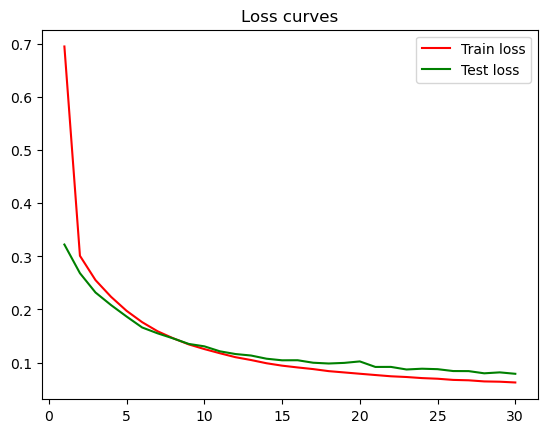

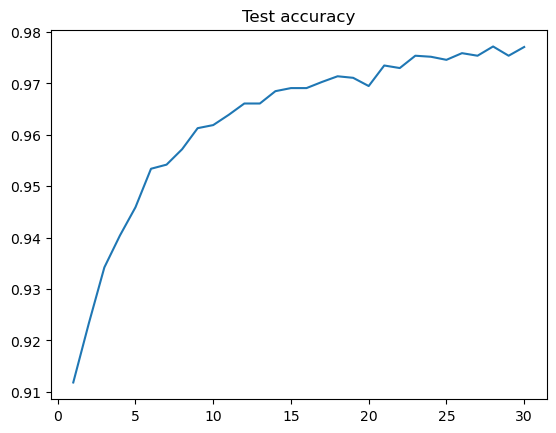

Training: lr=0.001, arhitecture=[100, 40, 20]
On untrained model, test set: acc=5.97, loss=2.3121
Epoch 1/30, train set: loss=2.1755
Epoch 1/30, test set: acc=53.54%, loss=1.9347
Epoch 2/30, train set: loss=1.5609
Epoch 2/30, test set: acc=69.47%, loss=1.2166
Epoch 3/30, train set: loss=1.0031
Epoch 3/30, test set: acc=80.07%, loss=0.8272
Epoch 4/30, train set: loss=0.7419
Epoch 4/30, test set: acc=83.72%, loss=0.6559
Epoch 5/30, train set: loss=0.6144
Epoch 5/30, test set: acc=85.75%, loss=0.5595
Epoch 6/30, train set: loss=0.5352
Epoch 6/30, test set: acc=87.25%, loss=0.4935
Epoch 7/30, train set: loss=0.4802
Epoch 7/30, test set: acc=88.20%, loss=0.4474
Epoch 8/30, train set: loss=0.4394
Epoch 8/30, test set: acc=88.87%, loss=0.4128
Epoch 9/30, train set: loss=0.4081
Epoch 9/30, test set: acc=89.27%, loss=0.3862
Epoch 10/30, train set: loss=0.3829
Epoch 10/30, test set: acc=89.98%, loss=0.3632
Epoch 11/30, train set: loss=0.3619
Epoch 11/30, test set: acc=90.50%, loss=0.3451
Epoch 1

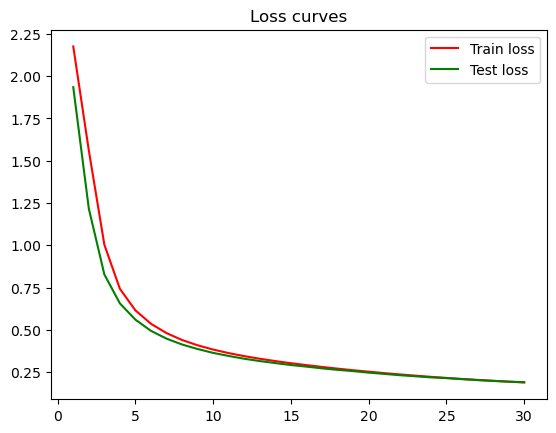

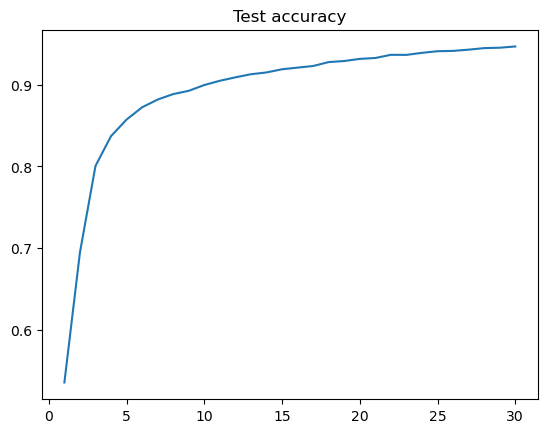

Training: lr=0.001, arhitecture=[200, 40]
On untrained model, test set: acc=7.98, loss=2.3088
Epoch 1/30, train set: loss=1.8963
Epoch 1/30, test set: acc=69.23%, loss=1.3662
Epoch 2/30, train set: loss=1.0499
Epoch 2/30, test set: acc=83.60%, loss=0.7998
Epoch 3/30, train set: loss=0.6877
Epoch 3/30, test set: acc=86.96%, loss=0.5759
Epoch 4/30, train set: loss=0.5338
Epoch 4/30, test set: acc=88.48%, loss=0.4724
Epoch 5/30, train set: loss=0.4562
Epoch 5/30, test set: acc=89.17%, loss=0.4164
Epoch 6/30, train set: loss=0.4112
Epoch 6/30, test set: acc=89.71%, loss=0.3820
Epoch 7/30, train set: loss=0.3817
Epoch 7/30, test set: acc=90.07%, loss=0.3587
Epoch 8/30, train set: loss=0.3606
Epoch 8/30, test set: acc=90.40%, loss=0.3413
Epoch 9/30, train set: loss=0.3443
Epoch 9/30, test set: acc=90.75%, loss=0.3282
Epoch 10/30, train set: loss=0.3312
Epoch 10/30, test set: acc=91.06%, loss=0.3169
Epoch 11/30, train set: loss=0.3203
Epoch 11/30, test set: acc=91.24%, loss=0.3073
Epoch 12/30

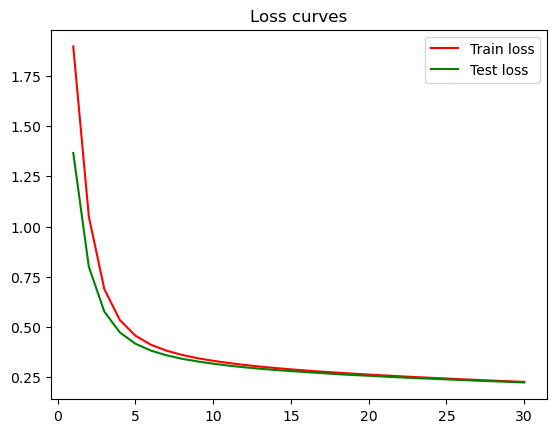

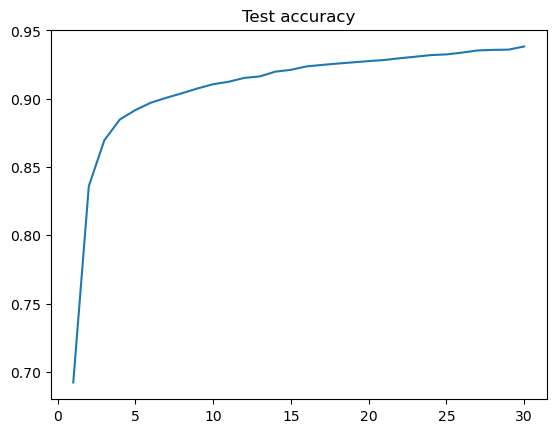

Training: lr=0.0001, arhitecture=[100, 40, 20]
On untrained model, test set: acc=7.62, loss=2.3108
Epoch 1/30, train set: loss=2.3013
Epoch 1/30, test set: acc=11.97%, loss=2.2896
Epoch 2/30, train set: loss=2.2798
Epoch 2/30, test set: acc=15.12%, loss=2.2678
Epoch 3/30, train set: loss=2.2573
Epoch 3/30, test set: acc=20.61%, loss=2.2440
Epoch 4/30, train set: loss=2.2319
Epoch 4/30, test set: acc=30.10%, loss=2.2165
Epoch 5/30, train set: loss=2.2020
Epoch 5/30, test set: acc=42.62%, loss=2.1833
Epoch 6/30, train set: loss=2.1654
Epoch 6/30, test set: acc=46.90%, loss=2.1424
Epoch 7/30, train set: loss=2.1205
Epoch 7/30, test set: acc=47.99%, loss=2.0924
Epoch 8/30, train set: loss=2.0665
Epoch 8/30, test set: acc=47.84%, loss=2.0333
Epoch 9/30, train set: loss=2.0042
Epoch 9/30, test set: acc=48.28%, loss=1.9670
Epoch 10/30, train set: loss=1.9358
Epoch 10/30, test set: acc=48.89%, loss=1.8957
Epoch 11/30, train set: loss=1.8635
Epoch 11/30, test set: acc=50.55%, loss=1.8216
Epoch 

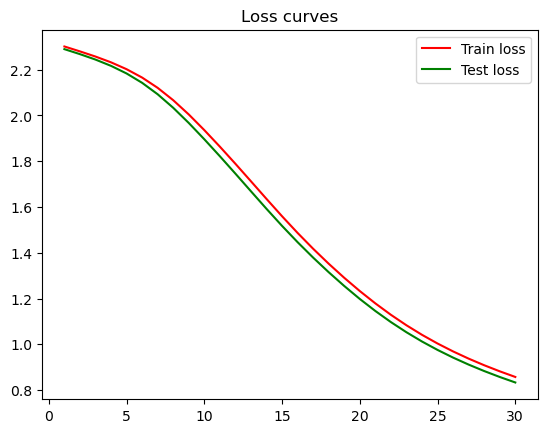

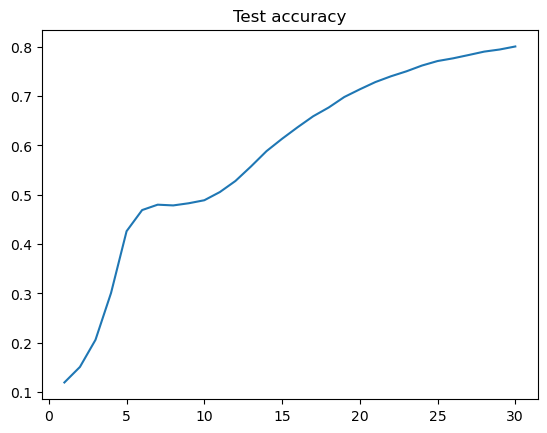

Training: lr=0.0001, arhitecture=[200, 40]
On untrained model, test set: acc=5.72, loss=2.3137
Epoch 1/30, train set: loss=2.2783
Epoch 1/30, test set: acc=34.03%, loss=2.2404
Epoch 2/30, train set: loss=2.2059
Epoch 2/30, test set: acc=52.64%, loss=2.1663
Epoch 3/30, train set: loss=2.1301
Epoch 3/30, test set: acc=60.17%, loss=2.0851
Epoch 4/30, train set: loss=2.0446
Epoch 4/30, test set: acc=62.47%, loss=1.9918
Epoch 5/30, train set: loss=1.9458
Epoch 5/30, test set: acc=63.55%, loss=1.8847
Epoch 6/30, train set: loss=1.8344
Epoch 6/30, test set: acc=63.84%, loss=1.7671
Epoch 7/30, train set: loss=1.7156
Epoch 7/30, test set: acc=64.16%, loss=1.6459
Epoch 8/30, train set: loss=1.5967
Epoch 8/30, test set: acc=64.88%, loss=1.5288
Epoch 9/30, train set: loss=1.4841
Epoch 9/30, test set: acc=66.13%, loss=1.4207
Epoch 10/30, train set: loss=1.3814
Epoch 10/30, test set: acc=67.87%, loss=1.3238
Epoch 11/30, train set: loss=1.2898
Epoch 11/30, test set: acc=70.02%, loss=1.2378
Epoch 12/3

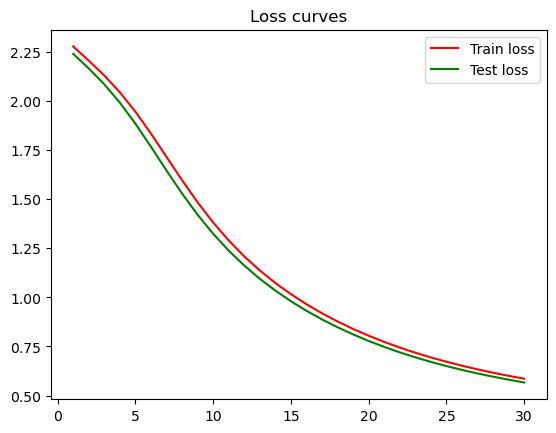

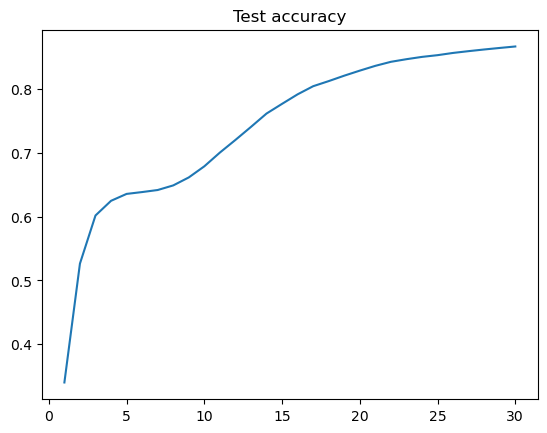

In [ ]:
# Scrieti antrenarea retelelor pe baza produsului cartezian dintre multimea candidate_lrs si candidate_architectures
# Fiecare antrenare va afisa log-urile similar cu antrenarile anteriore
# Pastrati modelul cu acuratete maxima si care sunt valorile pentru learning rate si arhitectura cu care a fost obtinut

In [ ]:
print(max_accuracy)
print(best_performing_params)